In [1]:
import numpy as np
from numpy import ones
from numpy_sugar import ddot
# import os
# import sys
import pandas as pd
from pandas_plink import read_plink1_bin
from numpy.linalg import cholesky
from numpy_sugar.linalg import economic_svd
import xarray as xr
from struct_lmm2 import StructLMM2
from limix.qc import quantile_gaussianize
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import struct_lmm2 # check that it refers to code in repo
struct_lmm2

<module 'struct_lmm2' from '/hps/nobackup/stegle/users/acuomo/git_repos/struct-lmm2/struct_lmm2/__init__.py'>

In [3]:
chrom = 2

In [4]:
# directory containing all input files
input_files_dir = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/new/input_files/"

In [5]:
## this file will map cells to donors, it will also only including donors we have single cell data (a subset of all of HipSci donors)
sample_mapping_file = input_files_dir+"sample_mapping_file.csv"
sample_mapping = pd.read_csv(sample_mapping_file, dtype={"genotype_individual_id": str, "phenotype_sample_id": str})

In [6]:
## extract unique individuals
donors = sample_mapping["genotype_individual_id"].unique()
donors.sort()
print("Number of unique donors: {}".format(len(donors)))

Number of unique donors: 126


In [7]:
## read in genotype file
plink_file = "/hps/nobackup/hipsci/scratch/genotypes/imputed/2017-03-27/Full_Filtered_SNPs_Plink/hipsci.wec.gtarray.HumanCoreExome.imputed_phased.20170327.genotypes.norm.renamed.bed"
G = read_plink1_bin(plink_file)
G.shape

Mapping files: 100%|██████████| 3/3 [06:01<00:00, 120.61s/it]


(1610, 10464962)

In [8]:
## read in GRM kinship matrix
kinship_file = "/hps/nobackup/hipsci/scratch/genotypes/imputed/2017-03-27/Full_Filtered_SNPs_Plink-F/hipsci.wec.gtarray.HumanCoreExome.imputed_phased.20170327.genotypes.norm.renamed.kinship"
K = pd.read_csv(kinship_file, sep="\t", index_col=0)
assert all(K.columns == K.index)

In [9]:
K = xr.DataArray(K.values, dims=["sample_0", "sample_1"], coords={"sample_0": K.columns, "sample_1": K.index})
K = K.sortby("sample_0").sortby("sample_1")
donors = sorted(set(list(K.sample_0.values)).intersection(donors))
print("Number of donors after kinship intersection: {}".format(len(donors)))

Number of donors after kinship intersection: 125


In [10]:
## subset to relevant donors
K = K.sel(sample_0=donors, sample_1=donors)
assert all(K.sample_0 == donors)
assert all(K.sample_1 == donors)

In [11]:
## and decompose such as K = L @ L.T
L_kinship = cholesky(K.values)
L_kinship = xr.DataArray(L_kinship, dims=["sample", "col"], coords={"sample": K.sample_0.values})
assert all(L_kinship.sample.values == K.sample_0.values)

In [12]:
del K
print("Sample mapping number of rows BEFORE intersection: {}".format(sample_mapping.shape[0]))
sample_mapping = sample_mapping[sample_mapping["genotype_individual_id"].isin(donors)]
print("Sample mapping number of rows AFTER intersection: {}".format(sample_mapping.shape[0]))

Sample mapping number of rows BEFORE intersection: 34256
Sample mapping number of rows AFTER intersection: 33964


In [13]:
# expand from donors to cells
L_expanded = L_kinship.sel(sample=sample_mapping["genotype_individual_id"].values)
assert all(L_expanded.sample.values == sample_mapping["genotype_individual_id"].values)

In [14]:
# environments
# cells by PCs (10)
E_file = input_files_dir+"20PCs.csv"
E = pd.read_csv(E_file, index_col = 0)
E = xr.DataArray(E.values, dims=["cell", "pc"], coords={"cell": E.index.values, "pc": E.columns.values})
E = E.sel(cell=sample_mapping["phenotype_sample_id"].values)
assert all(E.cell.values == sample_mapping["phenotype_sample_id"].values)

In [15]:
E.head()

<xarray.DataArray (cell: 5, pc: 5)>
array([[-12.24123085, -12.61521861,   0.54720859, -11.41120382,
         -7.05208793],
       [  4.50912496, -27.06629325,   7.55644688,  -9.36686849,
         -1.4719908 ],
       [ -1.27341425, -23.32348367,  -0.50190342,  -3.81957479,
         -1.46324269],
       [-14.96256642, -12.96636729,   1.96740599,  -5.44632616,
        -13.31600698],
       [ -6.34166538, -19.01046679,  -2.82497497,  -2.46276866,
         -7.5214263 ]])
Coordinates:
  * cell     (cell) object '21843_1#10' '21843_1#100' ... '21843_1#103'
  * pc       (pc) object 'PC1' 'PC2' 'PC3' 'PC4' 'PC5'

In [16]:
G_sel = G.where(G.chrom == str(chrom), drop=True)
G_exp = G_sel.sel(sample=sample_mapping["genotype_individual_id"].values)
assert all(L_expanded.sample.values == G_exp.sample.values)

/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]
/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [17]:
G_sel.shape

(1610, 903871)

In [18]:
G_exp.shape

(33964, 903871)

In [19]:
# sub-select E prior to decomposition of background term K*EEt
n_factors = 1
E = E.values[:,0:n_factors]

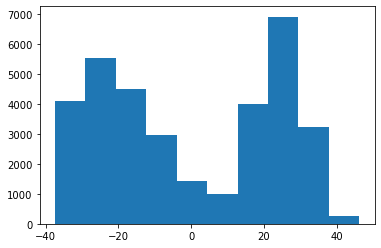

In [20]:
plt.hist(E[:,0])
plt.show()

In [21]:
# get decomposition of K*EEt 
# i.e. get Li's such that K*EEt = L1L1t + L2L2t + ..
[U, S, _] = economic_svd(E)
del _
us = U * S
Ls = [ddot(us[:,i], L_expanded) for i in range(us.shape[1])]
del us

In [22]:
# Phenotype
phenotype_file = input_files_dir+"phenotype.csv.pkl"
phenotype = pd.read_pickle(phenotype_file)
print("Phenotype shape BEFORE selection: {}".format(phenotype.shape))
phenotype = xr.DataArray(phenotype.values, dims=["trait", "cell"], coords={"trait": phenotype.index.values, "cell": phenotype.columns.values})
phenotype = phenotype.sel(cell=sample_mapping["phenotype_sample_id"].values)
print("Phenotype shape AFTER selection: {}".format(phenotype.shape))
assert all(phenotype.cell.values == sample_mapping["phenotype_sample_id"].values)

Phenotype shape BEFORE selection: (11231, 34256)
Phenotype shape AFTER selection: (11231, 33964)


In [23]:
# Filter on specific gene-SNP pairs
# eQTL from endodiff (ips+mesendo+defendo)
endo_eqtl_file = input_files_dir+"endodiff_eqtl_allconditions_FDR10pct.csv"
endo_eqtl = pd.read_csv(endo_eqtl_file, index_col = False)
endo_eqtl["chrom"] = [int(i[:i.find("_")]) for i in endo_eqtl["snp_id"]]
genes = endo_eqtl[endo_eqtl['chrom']==int(chrom)]['feature'].unique()

In [24]:
len(genes)

230

In [25]:
# set up model
# starting with (fixed effect) covariates
n_samples = phenotype.shape[1]
M = ones((n_samples, 1))

In [26]:
# column gaussianise environment(s)
E = quantile_gaussianize(E)

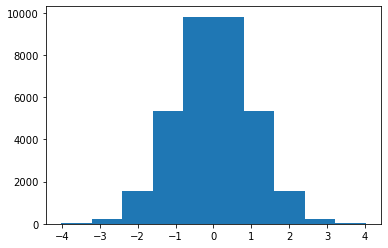

In [27]:
plt.hist(E[:,0])
plt.show()

In [44]:
i = 7
trait_name = genes[i]
trait_name

'ENSG00000136717_BIN1'

In [45]:
y = phenotype.sel(trait=trait_name)
# plt.hist(y)
# plt.show()

In [46]:
# (y == 0).astype(int).sum()/len(y)

In [47]:
# if (y == 0).astype(int).sum()/len(y)>0.3:
#     print("Over 30 percent zeroes, skipping gene")

In [48]:
y = quantile_gaussianize(y)
# plt.hist(y)
# plt.show()

In [49]:
# select SNPs for a given gene
leads = endo_eqtl[endo_eqtl['feature']==trait_name]['snp_id'].unique()
leads

array(['2_127863029_C_T', '2_127846505_T_C', '2_127859418_T_C'],
      dtype=object)

In [50]:
G_tmp = G_exp[:,G_exp['snp'].isin(leads)]
G_tmp.shape   

(33964, 3)

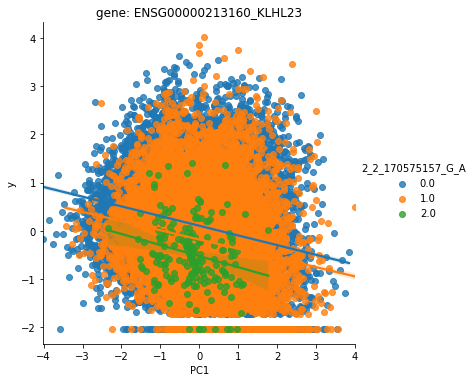

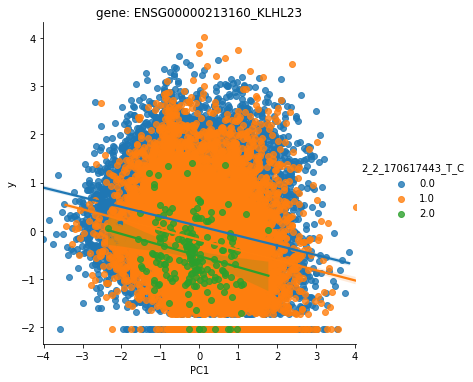

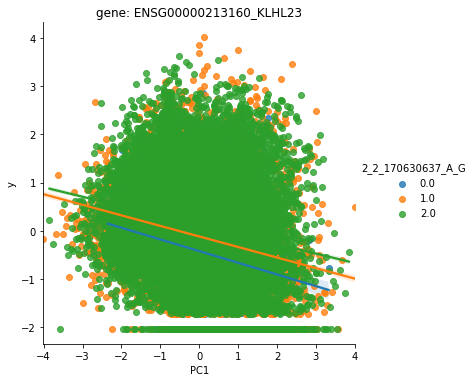

In [43]:
# ENSG00000213160_KLHL23
g = G_tmp.compute()
d = np.concatenate([E[:,0].reshape(E.shape[0],1), y.values.reshape(y.shape[0],1), g.values],axis=1)
c = ['PC1','y']
for i in range(g.shape[1]):
    c.append(str(g.variant[i].values))
df = pd.DataFrame(data=d, columns=c)
for i in range(g.shape[1]):
    sns.lmplot(x='PC1', y='y', hue=str(g.variant[i].values), data=df)
    plt.title("gene: "+trait_name)
    plt.show()

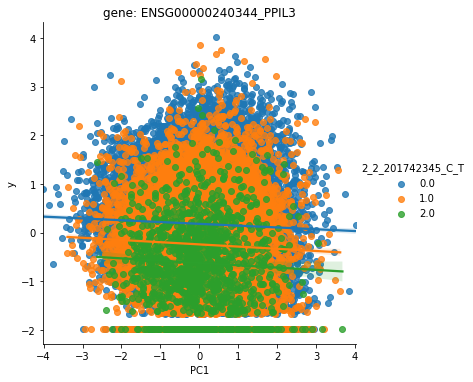

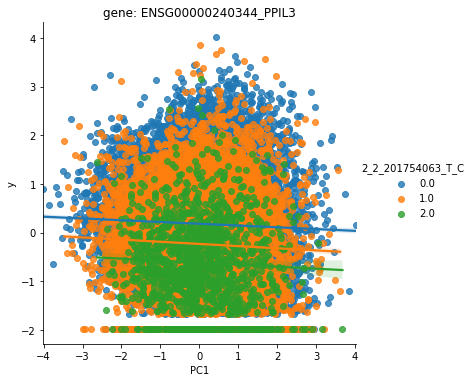

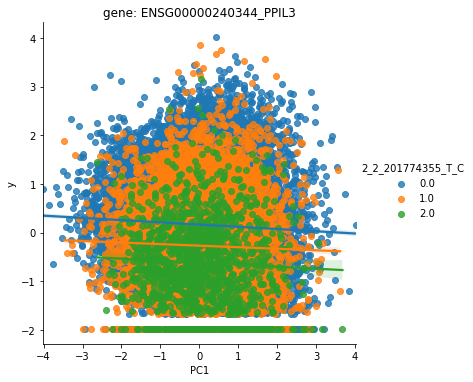

In [35]:
# ENSG00000240344_PPIL3
g = G_tmp.compute()
d = np.concatenate([E[:,0].reshape(E.shape[0],1), y.values.reshape(y.shape[0],1), g.values],axis=1)
c = ['PC1','y']
for i in range(g.shape[1]):
    c.append(str(g.variant[i].values))
df = pd.DataFrame(data=d, columns=c)
for i in range(g.shape[1]):
    sns.lmplot(x='PC1', y='y', hue=str(g.variant[i].values), data=df)
    plt.title("gene: "+trait_name)
    plt.show()

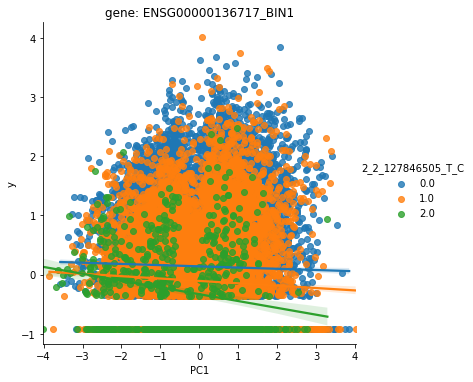

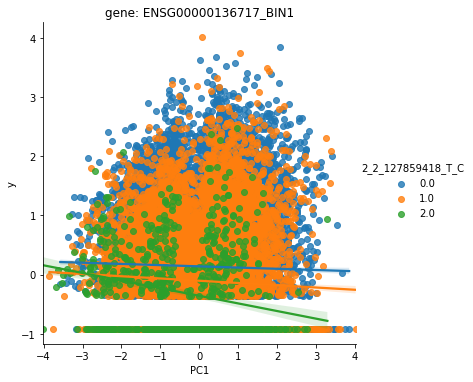

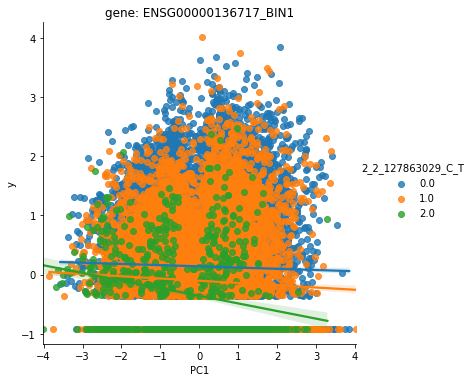

In [51]:
# ENSG00000136717_BIN1
g = G_tmp.compute()
d = np.concatenate([E[:,0].reshape(E.shape[0],1), y.values.reshape(y.shape[0],1), g.values],axis=1)
c = ['PC1','y']
for i in range(g.shape[1]):
    c.append(str(g.variant[i].values))
df = pd.DataFrame(data=d, columns=c)
for i in range(g.shape[1]):
    sns.lmplot(x='PC1', y='y', hue=str(g.variant[i].values), data=df)
    plt.title("gene: "+trait_name)
    plt.show()

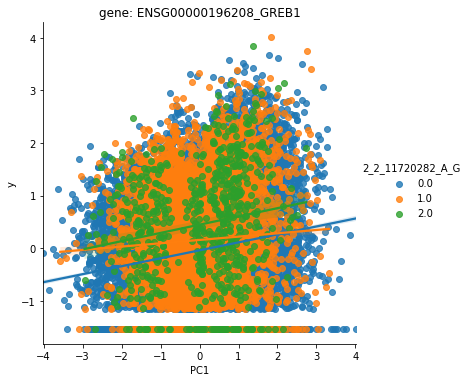

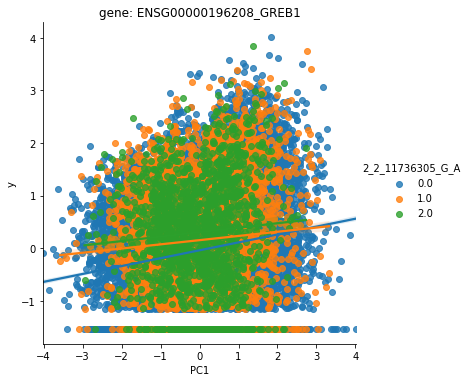

In [197]:
# ENSG00000196208_GREB1
g = G_tmp.compute()
d = np.concatenate([E[:,0].reshape(E.shape[0],1), y.values.reshape(y.shape[0],1), g.values],axis=1)
c = ['PC1','y']
for i in range(g.shape[1]):
    c.append(str(g.variant[i].values))
df = pd.DataFrame(data=d, columns=c)
for i in range(g.shape[1]):
    sns.lmplot(x='PC1', y='y', hue=str(g.variant[i].values), data=df)
    plt.title("gene: "+trait_name)
    plt.show()

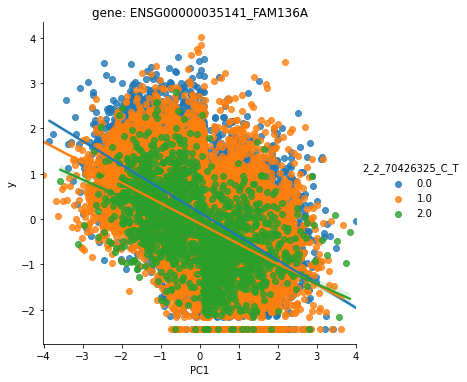

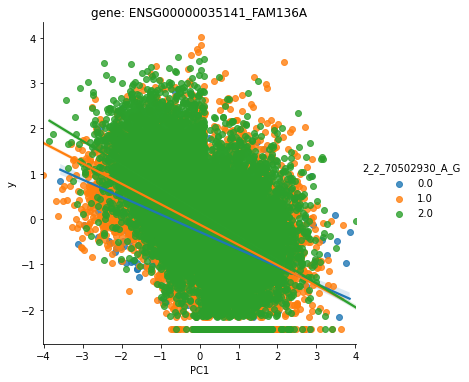

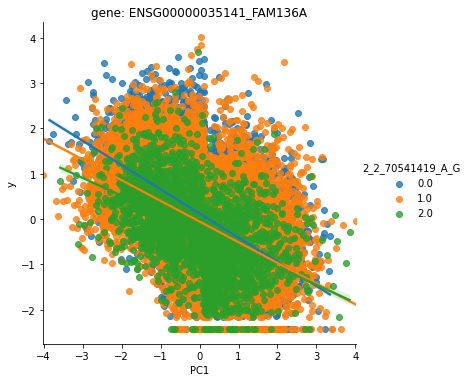

In [189]:
# ENSG00000035141_FAM136A
g = G_tmp.compute()
d = np.concatenate([E[:,0].reshape(E.shape[0],1), y.values.reshape(y.shape[0],1), g.values],axis=1)
c = ['PC1','y']
for i in range(g.shape[1]):
    c.append(str(g.variant[i].values))
df = pd.DataFrame(data=d, columns=c)
for i in range(g.shape[1]):
    sns.lmplot(x='PC1', y='y', hue=str(g.variant[i].values), data=df)
    plt.title("gene: "+trait_name)
    plt.show()

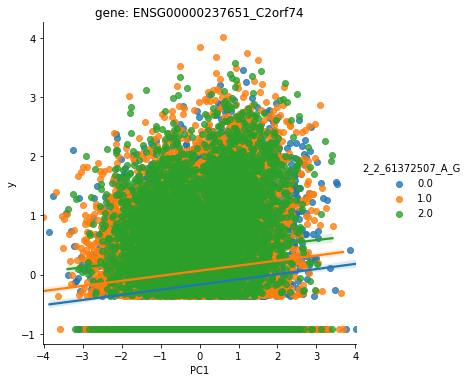

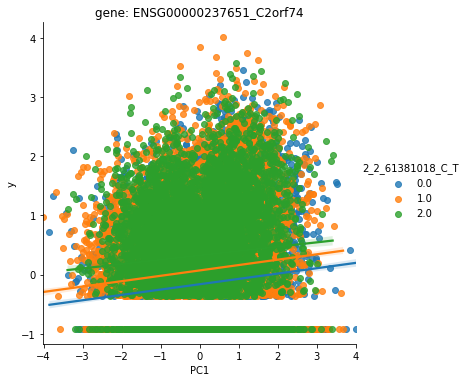

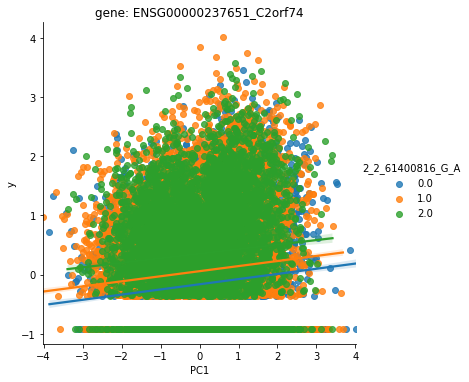

In [181]:
# ENSG00000237651_C2orf74
g = G_tmp.compute()
d = np.concatenate([E[:,0].reshape(E.shape[0],1), y.values.reshape(y.shape[0],1), g.values],axis=1)
c = ['PC1','y']
for i in range(g.shape[1]):
    c.append(str(g.variant[i].values))
df = pd.DataFrame(data=d, columns=c)
for i in range(g.shape[1]):
    sns.lmplot(x='PC1', y='y', hue=str(g.variant[i].values), data=df)
    plt.title("gene: "+trait_name)
    plt.show()

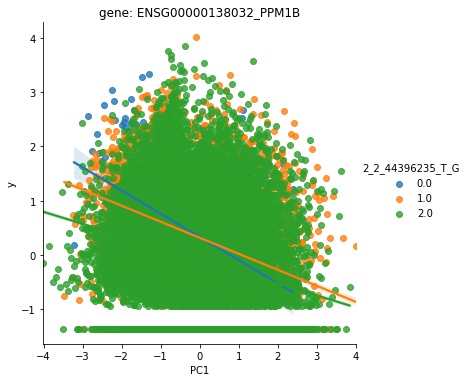

In [173]:
# ENSG00000138032_PPM1B
g = G_tmp.compute()
d = np.concatenate([E[:,0].reshape(E.shape[0],1), y.values.reshape(y.shape[0],1), g.values],axis=1)
c = ['PC1','y']
for i in range(g.shape[1]):
    c.append(str(g.variant[i].values))
df = pd.DataFrame(data=d, columns=c)
for i in range(g.shape[1]):
    sns.lmplot(x='PC1', y='y', hue=str(g.variant[i].values), data=df)
    plt.title("gene: "+trait_name)
    plt.show()

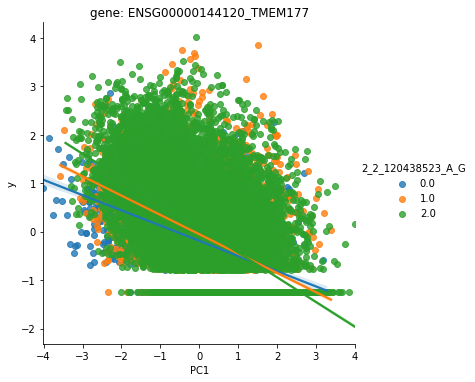

In [165]:
# ENSG00000144120_TMEM177
g = G_tmp.compute()
d = np.concatenate([E[:,0].reshape(E.shape[0],1), y.values.reshape(y.shape[0],1), g.values],axis=1)
c = ['PC1','y']
for i in range(g.shape[1]):
    c.append(str(g.variant[i].values))
df = pd.DataFrame(data=d, columns=c)
for i in range(g.shape[1]):
    sns.lmplot(x='PC1', y='y', hue=str(g.variant[i].values), data=df)
    plt.title("gene: "+trait_name)
    plt.show()

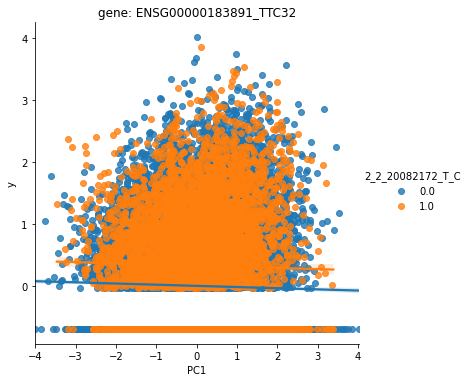

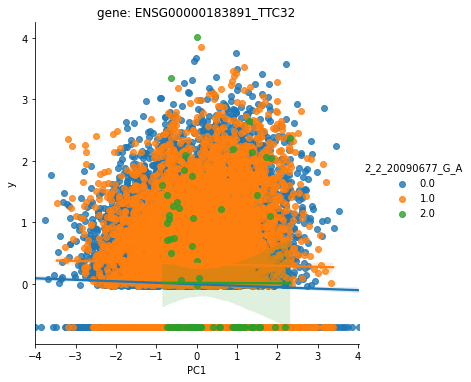

In [157]:
# ENSG00000183891_TTC32
g = G_tmp.compute()
d = np.concatenate([E[:,0].reshape(E.shape[0],1), y.values.reshape(y.shape[0],1), g.values],axis=1)
c = ['PC1','y']
for i in range(g.shape[1]):
    c.append(str(g.variant[i].values))
df = pd.DataFrame(data=d, columns=c)
for i in range(g.shape[1]):
    sns.lmplot(x='PC1', y='y', hue=str(g.variant[i].values), data=df)
    plt.title("gene: "+trait_name)
    plt.show()

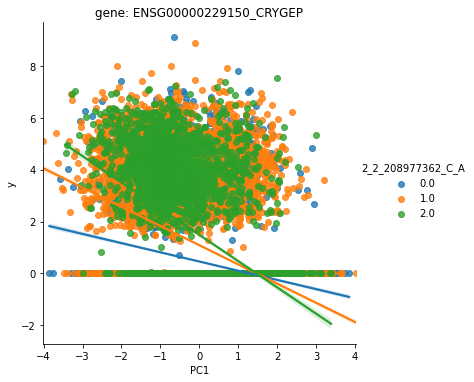

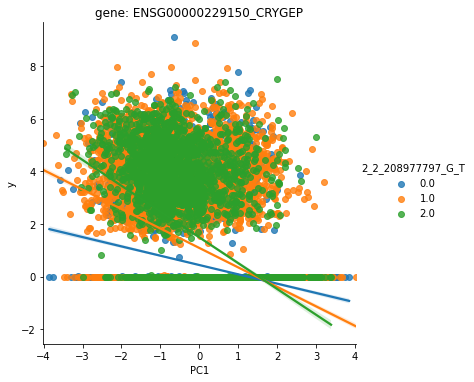

In [149]:
# ENSG00000229150_CRYGEP
g = G_tmp.compute()
d = np.concatenate([E[:,0].reshape(E.shape[0],1), y.values.reshape(y.shape[0],1), g.values],axis=1)
c = ['PC1','y']
for i in range(g.shape[1]):
    c.append(str(g.variant[i].values))
df = pd.DataFrame(data=d, columns=c)
for i in range(g.shape[1]):
    sns.lmplot(x='PC1', y='y', hue=str(g.variant[i].values), data=df)
    plt.title("gene: "+trait_name)
    plt.show()

In [ ]:
# ENSG00000229150_CRYGEP
g = G_tmp.compute()
for i in range(g.shape[1]):
    plt.scatter(E[:,0],y.values, c = g[:,i], alpha=0.1)
    plt.title("gene "+trait_name+", SNP="+str(g.variant[i].values))
    plt.show()